In [16]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
import datetime
from scipy import sparse
from scipy import stats
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances
import h5py

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

# Configs  

In [2]:
time_stamp = datetime.datetime.now().date()
print(time_stamp)

config_f = 'config_scf_8mods_data_freeze_190917.py' 
exec("from {} import *".format(config_f.split('.')[0]))

2020-05-13


In [3]:
output_figures

'/cndd/fangming/CEMBA/data/MOp_all/results/figures/mop_8mods_0915_k30_{}.{}'

In [4]:
# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

## Read in data 

In [5]:
log = snmcseq_utils.create_logger()
logging.info('*')

05/13/2020 12:09:59 AM *


In [6]:
# back compatible
f_mod_annot = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_datamod_annotation.tsv'
f = f_mod_annot
df_mod_annot = pd.read_csv(f, sep="\t", index_col='Modality') 

# update settings
settings_new = collections.OrderedDict()
for mod, mod_info in settings.items():
    new_dict = collections.OrderedDict()
    for item_key in mod_info._asdict().keys():
        if item_key == 'name':
            new_dict[item_key] = df_mod_annot.loc[mod, 'Name'] 
        elif item_key == 'color':
            new_dict[item_key] = df_mod_annot.loc[mod, 'Color'] 
        else:
            # unchanged 
            new_dict[item_key] = mod_info._asdict()[item_key]
    
    _items = [val for key, val in new_dict.items()]
    settings_new[mod] = Mod_info(*_items) 
settings = settings_new
# settings

In [7]:
metas = collections.OrderedDict()
for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(mod, metas[mod].shape)

snmcseq_gene (9366, 32)
snatac_gene (54844, 13)


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


smarter_cells (6244, 129)
smarter_nuclei (5911, 146)
10x_cells_v2 (121440, 8)
10x_cells_v3 (69727, 8)
10x_nuclei_v3 (39706, 8)
10x_nuclei_v3_macosko (101647, 19)


In [8]:
df_genes = pd.read_csv(PATH_GENEBODY_ANNOTATION, sep='\t')
df_genes['gene_id_abbr'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
df_genes = df_genes.set_index('gene_id_abbr')
df_genes_v2 = df_genes.reset_index().groupby('gene_name').first()
print(df_genes.shape)
print(df_genes_v2.shape)
df_genes.head()

(53379, 7)
(53278, 7)


,gene_id,gene_name,chr,start,end,strand,gene_type
gene_id_abbr,,,,,,,
ENSMUSG00000102693,ENSMUSG00000102693.1,4933401J01Rik,chr1,3073253,3074322,+,TEC
ENSMUSG00000064842,ENSMUSG00000064842.1,Gm26206,chr1,3102016,3102125,+,snRNA
ENSMUSG00000051951,ENSMUSG00000051951.5,Xkr4,chr1,3205901,3671498,-,protein_coding
ENSMUSG00000102851,ENSMUSG00000102851.1,Gm18956,chr1,3252757,3253236,+,processed_pseudogene
ENSMUSG00000103377,ENSMUSG00000103377.1,Gm37180,chr1,3365731,3368549,-,TEC


In [10]:
mods_ordered = [
    'snatac_gene',
    'snmcseq_gene',
    'smarter_nuclei',
    'smarter_cells',
    '10x_cells_v3',
    '10x_nuclei_v3',
    '10x_nuclei_v3_macosko',
    '10x_cells_v2', 
    ]

mods_updated = [
    'smarter_cells',
    '10x_cells_v3',
    '10x_cells_v2', 
    'smarter_nuclei',
    '10x_nuclei_v3_macosko',
    '10x_nuclei_v3',
    'snatac_gene',
    'mch',
    'mcg',
]

In [11]:
clsts_manual_order = collections.OrderedDict({
 '4-1': 'L2/3 IT ',
 '4-2': 'L2/3 IT ',
 '1-1': 'L5 IT Rspo1_1',
 '1-2': 'L5 IT Rspo2_1',
 '3-2': 'L5 IT S100b',
 '3-1': 'L6 IT_2',
 '3-3': 'L6 IT Car3',
    
 '9-1': 'L5 ET_1',
 '9-2': 'L5 ET_2',
    
 '2-1': 'L6 CT Cpa6',
 '2-2': 'L6 CT Cpa6',
 '2-3': 'L6 CT Nxph2 Pou3f2',
    
 '8-1': 'L6b Shisa6_1',
 '8-2': 'L6b Ror1',
 '8-3': 'L6b Kcnip1_2',
    
 '7-1': 'L6 NP Trh_1',
 '7-2': 'L5 NP Slc17a8',
    
 '5-1': 'Pvalb Reln',
 '5-4': 'Pvalb Gabrg1',
 '5-5': 'Pvalb Vipr2',
    
 '5-2': 'Sst Myh8_2',
 '5-3': 'Sst Calb2',
 '10-1': 'Sst Chodl',
    
 '6-1': 'Vip Chat',
 '6-3': 'Vip Igfbp6',
 '6-5': 'Sncg Col14a1',
    
 '6-2': 'Lamp5 Slc35d3',
 '6-4': 'Lamp5 Pdlim5',
 '6-6': 'Lamp5 Lhx6',
})


clsts_uniq = np.array(list(clsts_manual_order.keys()))
print(len(clsts_uniq))

29


In [12]:
f_format = '/cndd2/fangming/miniatlas/cluster_level/cell_mean/gene_features_{}_round2.tsv'
centroid_dfs = {}
for mod in mods_selected:
    print(mod)
    if settings[mod].mod_category == 'mc':
        for mod_update in ['mcg', 'mch']:
            f = f_format.format(mod_update)
            centroid_dfs[mod_update] = pd.read_csv(f, sep='\t', index_col=0)
    else:
        f = f_format.format(mod)
        centroid_dfs[mod] = pd.read_csv(f, sep='\t', index_col=0)
    
print(centroid_dfs.keys())
    

snmcseq_gene
snatac_gene
smarter_cells
smarter_nuclei
10x_cells_v2
10x_cells_v3
10x_nuclei_v3
10x_nuclei_v3_macosko
dict_keys(['mcg', 'mch', 'snatac_gene', 'smarter_cells', 'smarter_nuclei', '10x_cells_v2', '10x_cells_v3', '10x_nuclei_v3', '10x_nuclei_v3_macosko'])


In [13]:
# clsts_uniq = np.sort(np.unique(df_info[joint_cluster]))

genes_inq = [
    'Lhx9',
#     'Fhl5',
#     'Pax6',
]

gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 

df_plots = {} 
for i, mod in enumerate(mods_ordered):
    if settings[mod].mod_category == 'mc':
        for mod_update in ['mcg', 'mch']:
            gene_data = centroid_dfs[mod_update].reindex(gene_ids_inq)

            gene_data.index = genes_inq
            gene_data = gene_data.dropna()
            df_plot = gene_data
            # normalize gene_data for each row except for mC (already normalized)
#             df_plot = settings[mod].mod_direction*df_plot
            df_plots[mod_update] = df_plot.reindex(
                                            index=genes_inq, 
                                            columns=clsts_uniq,
                                            )
    else:
        gene_data = centroid_dfs[mod].reindex(gene_ids_inq)
        
        gene_data.index = genes_inq
        gene_data = gene_data.dropna()
        df_plot = gene_data
        # normalize gene_data for each row except for mC (already normalized)
#         df_plot = settings[mod].mod_direction*df_plot
#         df_plot = df_plot.divide(df_plot.max(axis=1), axis=0)
        df_plots[mod] = df_plot.reindex(
                                        index=genes_inq, 
                                        columns=clsts_uniq,
                                        )

In [14]:
[i for i, (key, val) in enumerate(clsts_manual_order.items()) if val.startswith('L6b')]

[12, 13, 14]

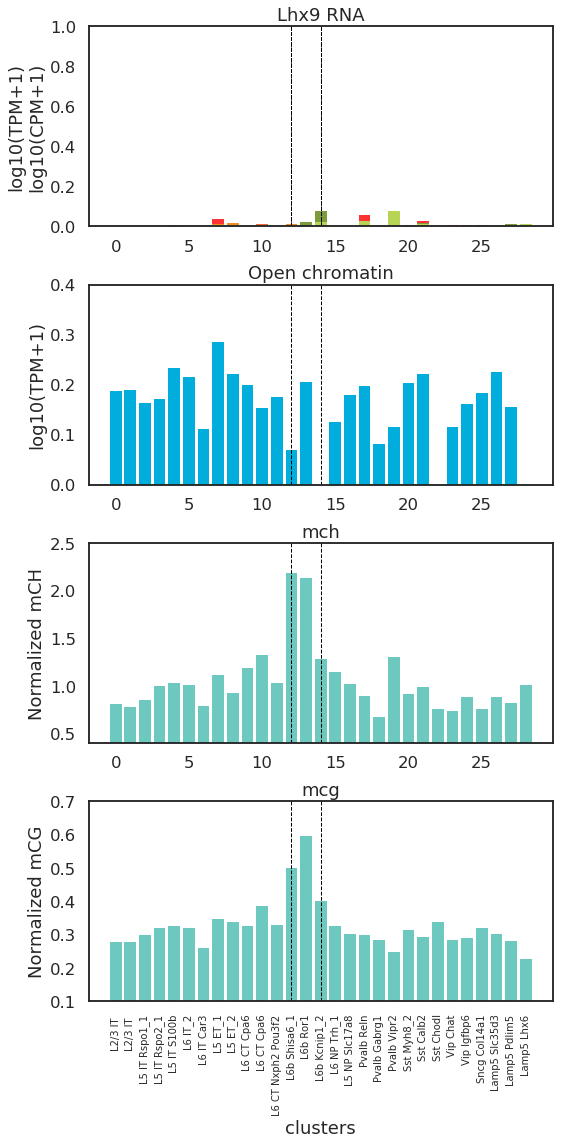

In [15]:
# nx = len(mods_updated)
# with sns.axes_style('ticks'):
with sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    nx = 1 
    ny = 4
    gene = genes_inq[0]
    fig, axs = plt.subplots(ny, nx, figsize=(8*nx, 4*ny))
    # axs = axs.flatten()
#     for j, gene in enumerate(genes_inq): 
    for i, mod in enumerate(mods_updated):
        if mod in settings.keys() and settings[mod].mod_category == 'rna':
            ax = axs[0]
            ax.set_ylim([0, 1])
            ax.set_ylabel('log10(TPM+1)\nlog10(CPM+1)')
            ax.set_title('{} RNA'.format(gene))
        elif mod in settings.keys() and settings[mod].mod_category == 'atac':
            ax = axs[1]
            ax.set_ylim([0, 0.4])
            ax.set_ylabel('log10(TPM+1)')
            ax.set_title('Open chromatin')
        elif mod == 'mch':
            ax = axs[2]
            ax.set_ylim([0.4, 2.5])
            ax.set_ylabel('Normalized mCH')
            ax.set_title(mod)
        elif mod == 'mcg':
            ax = axs[3]
            ax.set_ylim([0.1, 0.7])
            ax.set_ylabel('Normalized mCG')
            ax.set_title(mod)

        if mod in ['mch', 'mcg']:
            color = settings['snmcseq_gene'].color
        else:
            color = settings[mod].color
            
        if gene == 'Lhx9':
            ax.axvline(12, linewidth=1, linestyle='--', color='black')
            ax.axvline(14, linewidth=1, linestyle='--', color='black')
        
        x = np.arange(df_plots[mod].shape[1])
        y = df_plots[mod].iloc[0]
        ax.bar(x, y, color=color)


        ax.set_aspect('auto')
    ax.set_xticks(x)
    ax.set_xticklabels([val for key, val in clsts_manual_order.items()], rotation=90, fontsize=10)
    ax.set_xlabel('clusters')
    
    fig.tight_layout()
    fig.savefig(output_figures.format('barplot_Lhx9', 'pdf'), bbox_inches='tight')
    plt.show()

### Statistics 
- wilconxon test one-side 
- effect size (fold change mCG)
- effect size (fold change mCH)
- effect size (fold change ATAC)

In [34]:
_data.filter(regex=r'^(?!8)')

4-1     0.807161
4-2     0.781248
1-1     0.850886
1-2     0.997287
3-2     1.032290
3-1     1.005817
3-3     0.787873
9-1     1.114979
9-2     0.920746
2-1     1.184771
2-2     1.326470
2-3     1.027865
7-1     1.149877
7-2     1.017760
5-1     0.893903
5-4     0.670090
5-5     1.297441
5-2     0.909121
5-3     0.986625
10-1    0.755935
6-1     0.732498
6-3     0.878259
6-5     0.751446
6-2     0.886372
6-4     0.814929
6-6     1.006953
Name: Lhx9, dtype: float64

In [46]:
mods_totest = [
    'mch',
    'mcg',
    'snatac_gene',
]

for mod in mods_totest:
    _data = df_plots[mod].T.loc[clsts_uniq, gene]
    _x = _data.filter(regex=r'^8-')
    _y = _data.filter(regex=r'^(?!8)')

    _, p = stats.mannwhitneyu(_x.values, _y.values, alternative='greater')
#     _, p = stats.mannwhitneyu(_x.values, _y.values)
    
    fc = _x.mean()/_y.mean()
    print(mod, p, fc)

mch 0.00447681898844 1.9746251335397849
mcg 0.0029163405953 1.641416654493349
snatac_gene 0.913209313433 0.536404121943778


In [47]:
mods_totest = [
    'mch',
    'mcg',
    'snatac_gene',
]

for mod in mods_totest:
    _data = df_plots[mod].T.loc[clsts_uniq, gene]
    _x = _data.filter(regex=r'^8-')
    _y = _data.filter(regex=r'^(?!8)')

#     _, p = stats.mannwhitneyu(_x.values, _y.values, alternative='greater')
    _, p = stats.mannwhitneyu(_x.values, _y.values)
    
    fc = _x.mean()/_y.mean()
    print(mod, p, fc)

mch 0.00447681898844 1.9746251335397849
mcg 0.0029163405953 1.641416654493349
snatac_gene 0.0986702698968 0.536404121943778
